# Problem statement

The idea is to forecast the mean of all COVID beds in the US for the upcoming 3 months based on historical data gathered and get the 95% and 80% intervals of the mean value corresponding to each day.

# Loading time series

In [3]:
# Importing the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
pd.options.display.float_format = '{:.4f}'.format

In [4]:
# Setting graph/plot parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [5]:
# Loading data
data = pd.read_csv('Hospitalization_all_locs.csv')


# Printing first five rows and data type of each column
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

   V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0   1       Abruzzo  2020-01-03       0.0000        0.0000        0.0000   
1   2       Abruzzo  2020-01-04       0.0000        0.0000        0.0000   
2   3       Abruzzo  2020-01-05       0.0000        0.0000        0.0000   
3   4       Abruzzo  2020-01-06       0.0000        0.0000        0.0000   
4   5       Abruzzo  2020-01-07       0.0000        0.0000        0.0000   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  ...  newICU_upper  \
0       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
1       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
2       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
3       0.0000        0.0000        0.0000       0.0000  ...        0.0000   
4       0.0000        0.0000        0.0000       0.0000  ...        0.0000   

   totdea_mean  totdea_lower  totdea_upper  bedover_mean  bedover_lower  \

# Data Wrangling

* We're grouping by date and applying sum because we have data on states, and all the mean points corresponding to states add up to resemble those for countries. 
* We're also eliminating all rows that have zeroes in mean, lower bound, and upper bound columns

In [6]:
data = data[['date', 'allbed_mean','allbed_lower', 'allbed_upper']].groupby(['date']).sum().reset_index()
data = data[(data['allbed_mean']!=0) & (data['allbed_lower']!=0) & (data['allbed_upper']!=0)]

In [7]:
# Fetching only columns of interest
allBedData = data[['date', 'allbed_mean']]
allBedData.head()

,date,allbed_mean
47,2020-02-19,57.0846
48,2020-02-20,82.5606
49,2020-02-21,114.9392
50,2020-02-22,170.6496
51,2020-02-23,219.8898


### Datetime conversion

Since, date column is having object data type, let's resolve that 

In [8]:
allBedData['date'] = pd.to_datetime(allBedData['date'])

Now, since there are multiple values corresponding to one date because we removed location column from this data, we need to group these dates and find out the final All COVID beds value corresponding to each date.

### Grouping the column by date

In [9]:
allBedData = allBedData.groupby(['date']).sum().reset_index()
allBedData.iloc[50:100]

,date,allbed_mean
50,2020-04-09,278047.0942
51,2020-04-10,283285.0831
52,2020-04-11,286242.9982
53,2020-04-12,287638.3861
54,2020-04-13,288537.4040
55,2020-04-14,293961.9217
56,2020-04-15,289404.9892
57,2020-04-16,283260.5578
58,2020-04-17,274905.1829
59,2020-04-18,266657.4541


In [10]:
#setting index to date
allBedData = allBedData.set_index('date')
allBedData.index

DatetimeIndex(['2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28',
               ...
               '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-11', '2020-07-12'],
              dtype='datetime64[ns]', name='date', length=145, freq=None)

In [11]:
# Keeping historical data till 25th April 2020
allBedData = allBedData[allBedData.index <= '2020-04-25']
allBedData.columns = ['value']
allBedData.tail()

,value
date,
2020-04-21,241787.6315
2020-04-22,233250.1858
2020-04-23,218926.0409
2020-04-24,204360.8804
2020-04-25,189741.0333


### Missing value analysis

We'll check is there's any missing value present in our data by applying isnull function on the dataset.

In [12]:
allBedData.isnull().any()

value    False
dtype: bool

Since, we get 'False' as the result, we can say that there are no missing values in the dataset.

### Detecting outliers

Firstly, let's follow graphical procedure to analyse if the data contains outliers or not. We'll use boxplot for this.

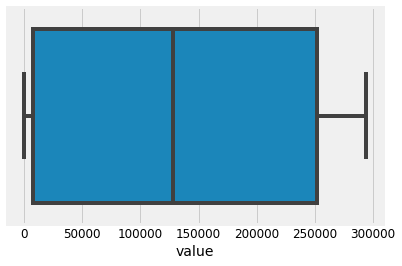

In [13]:
import seaborn as sns
sns.boxplot(x=allBedData['value'])

The boxplot tells that there're no outliers in the data as there's no point which is lying outside of whiskers. Let's now see this via z-scores.

In [14]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(allBedData))
print(z)

[[1.157939  ]
 [1.15771702]
 [1.15743489]
 [1.15694947]
 [1.15652043]
 [1.15587875]
 [1.15524785]
 [1.15407469]
 [1.15204149]
 [1.14982989]
 [1.1466567 ]
 [1.14252451]
 [1.1404219 ]
 [1.13042417]
 [1.1231647 ]
 [1.11028206]
 [1.09677676]
 [1.08136358]
 [1.06320017]
 [1.04934059]
 [1.01795815]
 [0.98174566]
 [0.95382254]
 [0.91239578]
 [0.8668554 ]
 [0.79963837]
 [0.71539518]
 [0.64741585]
 [0.57574412]
 [0.46969296]
 [0.37096064]
 [0.27389128]
 [0.15496546]
 [0.04546864]
 [0.04848085]
 [0.15215852]
 [0.28263732]
 [0.41328612]
 [0.54839297]
 [0.6474119 ]
 [0.73549596]
 [0.80412358]
 [0.85937781]
 [0.97035899]
 [1.04937028]
 [1.11024012]
 [1.17263708]
 [1.23651378]
 [1.24831503]
 [1.24797622]
 [1.26427254]
 [1.30991273]
 [1.33568594]
 [1.34784438]
 [1.3556778 ]
 [1.40294327]
 [1.36323733]
 [1.30969903]
 [1.23689611]
 [1.16503114]
 [1.09450198]
 [1.0227937 ]
 [0.94833281]
 [0.87394345]
 [0.74913281]
 [0.62222214]
 [0.49483496]]


As can be seen from above array, every value has z-score less than +3 or greater than -3. Thus, no outliers are present in the data.

# Time-series analysis

### Extracting time series from dataframe

In [15]:
# Converting allBedData into time-series
ts = allBedData['value']
ts.head()

date
2020-02-19    57.0846
2020-02-20    82.5606
2020-02-21   114.9392
2020-02-22   170.6496
2020-02-23   219.8898
Name: value, dtype: float64

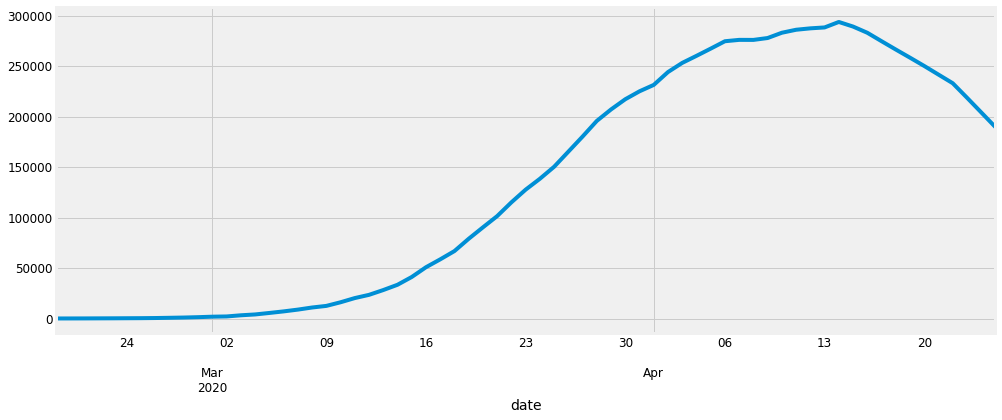

In [16]:
# Visualizing the time-series
pd.plotting.register_matplotlib_converters()
ts.plot(figsize=(15, 6))
plt.show()

The time-series stays close to 0 till the end of February 2020 and begins increasing after that. It keeps on increasing till mid-April where it reaches the highest point and then begins decreasing.

### Decomposing the time-series

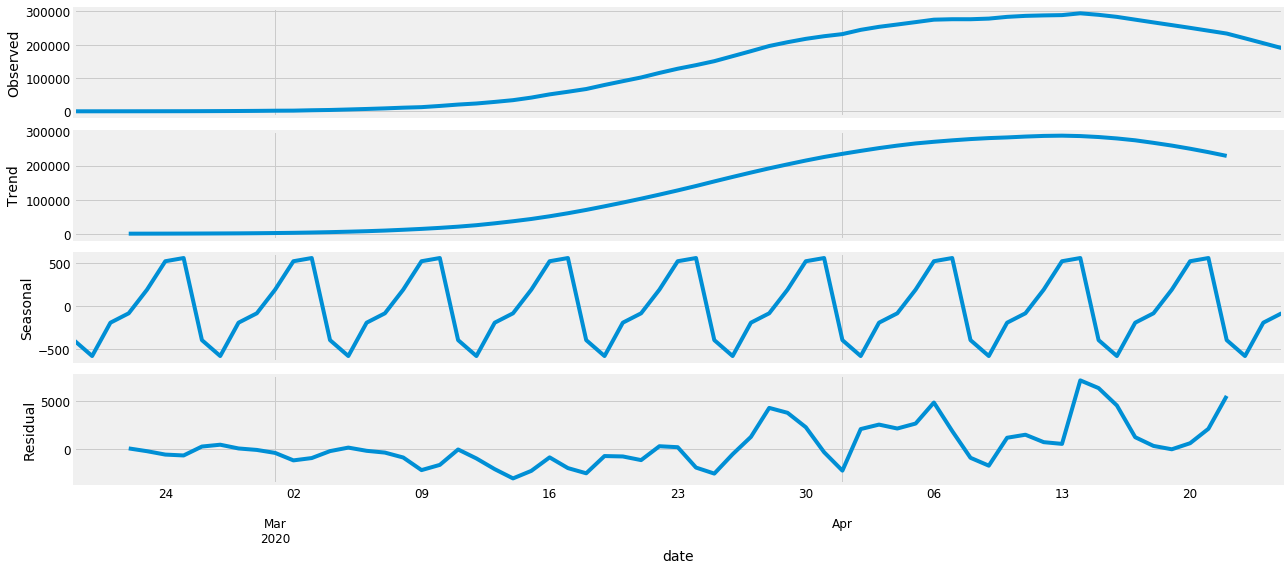

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

We can see that besides trend, there is high amount of seasonality within the data.

# Checking Stationarity

 In a time-series, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

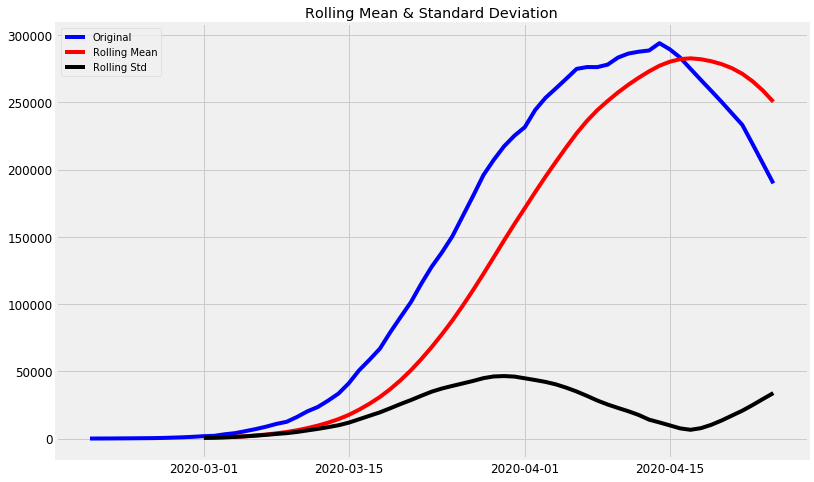

Results of Dickey-Fuller Test:
p-value = 0.0003. The series is likely stationary.
Test Statistic                -4.3614
p-value                        0.0003
#Lags Used                     8.0000
Number of Observations Used   58.0000
Critical Value (1%)           -3.5485
Critical Value (5%)           -2.9128
Critical Value (10%)          -2.5941
dtype: float64


In [19]:
test_stationarity(ts)

We can see that this time-series is stationary with p value of 0.00.

# Plotting ACF and PACF 

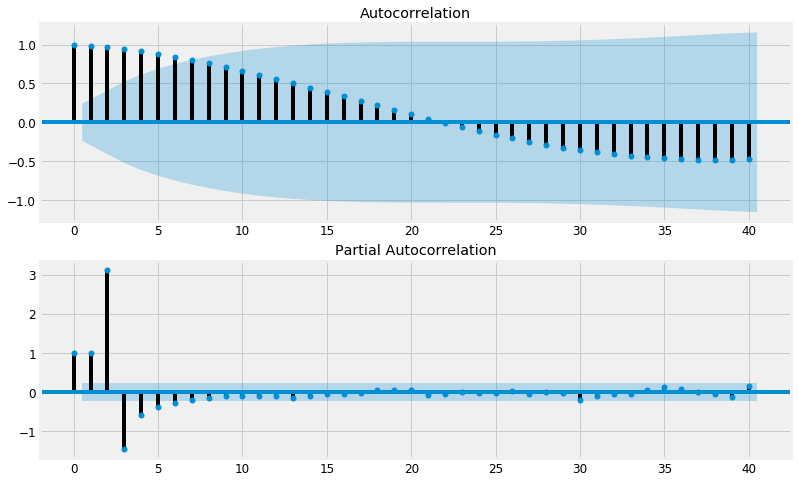

In [20]:
# Plotting ACF
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)# , lags=40

Since seasonality is also present in the data as can be seen from above graphs, after 15 days, we're seeing some sine wave like pattern, let's consider SARIMA.

# Forecasting the time-series with ARIMA

### Understanding ARIMA

ARIMA, an acronym for Autoregressive Integrated Moving Average, is a combination of two terms - (i) AR (ii) MA
* AR corresponds to the difference value. This is today's value minus yesterday's value or value-on-value change.
* MA corresponds to moving average terms.

Besides this, we have seen that there's high amount of seasonality in the time-series. Therefore, we will be using Seasonal ARIMA or SARIMA in this case.

In [21]:
# Keeping the p, d and q to be bounded in [0,3)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


This step is parameter selection for our SARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. Parameters corresponding to lowest AIC are the ones that we'd choose.

In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1784.3525764434823
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1452.4767383233195
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1382.6000838986922
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1035.5555912990562
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1084.5395162268155


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:855.2082076027588
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1403.8726021773819
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1354.8454986210643
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1096.4942394575153
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1035.2430756100346
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:801.2070719302297


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1249.3692118549789
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:1066.7940231950352
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:1060.5587251455174


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:760.5483188522119
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:749.3447904583384


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:435.9064039700135


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:421.0683726615843
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1712.6755149645624
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1389.9335071435487
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1320.6733848135173


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1018.6393231448003
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:1027.1010980334845


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:2636.7598772907127
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1441.7288450839726
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1389.7121313320515


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1072.9353604796538
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1020.4520441555097


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:779.829527744208
ARIMA(0, 0, 1)x(1, 2, 1, 12)12 - AIC:nan


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:1129.2444379837698


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:1131.0792594159643


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:772.6550592066033


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:774.4710952080966


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:477.65067982287803


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:479.4199368109075
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:1681.5492257751316


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:1367.4839792543482
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:1292.5019000801046


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:996.3042800752694
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:999.175264778036


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:2532.3331945350874
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:1445.2152691847225
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:1368.394072330228
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:1071.5017407281503


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:998.2074456671658


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:777.7335854605369


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:2592.0107762592734
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:1133.3070439644118


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:1135.2673442171317


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:775.4434115981911


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:777.4106573552227


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:480.50465097189704


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:482.39040390302426
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1352.1721139012734
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1090.6028741121213
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1115.0905201065352
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:876.7427051734936
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:874.0043858580746


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:1122.3107963892064
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1125.8411115570716
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1094.5533835099664
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:890.286251940637
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:861.0157036344011
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:648.0654691180545


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:1124.6933264415188
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:859.3249868713017
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:861.6680493430141
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:624.990061781343


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:614.9586010982181
ARIMA(0, 1, 0)x(2, 2, 0, 12)12 - AIC:388.6999426177354


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 1, 0)x(2, 2, 1, 12)12 - AIC:527.748223669264
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1294.3793947266436
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1050.7899803233138
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1069.4484977447885
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:831.1542730164974


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:829.9827566970259


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 1, 12)12 - AIC:1013.7347172559716
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1094.5143687416905
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1030.0405892830854
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:868.1535742418156
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:821.9772774588056


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 1, 1)x(1, 2, 0, 12)12 - AIC:628.868951151026


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 1, 12)12 - AIC:1203.3234850181364


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC:829.1896038300642
ARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC:851.469665426174


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:622.438948131107


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:588.6380626015089


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:381.0230911940651


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 1, 1)x(2, 2, 1, 12)12 - AIC:791.3806532544974
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:1265.891838873016
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:979.7193769677762
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:999.2615294314352


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:773.2840782703554
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:798.358365456024


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 1, 2)x(0, 2, 1, 12)12 - AIC:1064.0665593918418
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:1049.565123393596
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:1005.4950670364144


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:831.8585268256788


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:765.6441830619489
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:617.7797611470999


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:826.5884609959346
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:812.2787154758704


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:813.4958400435247


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:591.9905623929538


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:577.6989648307156
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:372.8508357701535


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:713.887958146299
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:1179.746169102922
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:968.3810682289171
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:980.6950937246605


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:755.8061019006354
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:797.9923908340165


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 2, 0)x(0, 2, 1, 12)12 - AIC:1256.0409183386396
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:986.6424836049189
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:964.4713271547814
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:779.7554241101798
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:758.4190165203245
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:572.1071491373147


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 2, 0)x(1, 2, 1, 12)12 - AIC:1235.3311671372212
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:772.9681741549357
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:774.6679554223439
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:558.8745138886226


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 1, 12)12 - AIC:557.7511837277189
ARIMA(0, 2, 0)x(2, 2, 0, 12)12 - AIC:329.2441138916919


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 1, 12)12 - AIC:329.7604686232515
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:1163.5127162289768
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:953.1199463338861
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:964.7205825548983


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:739.475420511313
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:779.8012239473409


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 2, 1)x(0, 2, 1, 12)12 - AIC:995.7557808155973
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:988.6634133559512
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:955.0816274045694
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:781.6476428528282
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:740.7437712291852
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:575.6655627767791


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:1178.026599558576
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:774.9681316265098


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:774.9692284303097
ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:561.3755244074364


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:559.7804898810708


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 0, 12)12 - AIC:331.1939148255593


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 1, 12)12 - AIC:331.1882311151162
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:1147.7493799361323
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:936.396163802206
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:946.2938516703383


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:725.1921231696729
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:760.6544367888973


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:1292.0517634298399
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:989.5321302951545
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:938.3914678173657
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:782.0129362895113


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:725.7627075242815


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:573.9516868199773


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:1099.925625954333
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:776.5088547442974


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:778.1421727162932


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:562.8825471163633


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:561.7207964311427


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:330.8646114467514


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:330.94959471924363
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1371.787631860392
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1113.6784128912316
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1136.7558156948292


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:886.8634567580963
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:893.4164422977445


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:1199.456544038518
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1127.908994229904
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1115.0346074786646


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:890.8468944337727
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:888.8634531553005


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:650.0397812472542


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:1164.182189014959


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:862.278646608041
ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:859.081988438564


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:625.8101763008929


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 1, 12)12 - AIC:620.3620127226662


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 0, 12)12 - AIC:384.10876390865934


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 1, 12)12 - AIC:386.04945670251084
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1313.9865285214883
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1071.0928710627682


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1083.7065018482645
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:843.1157351723921
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:846.4244481589362


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood

ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:1241.8154802551255
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1095.1869164385557
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1081.2915017601579
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:864.1699651665995


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:845.0934995578033


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:626.5247758605786


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:1265.0590203406516
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:850.2684445158816


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:850.8381546214918


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:617.4049767702841


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:616.7679879161517


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:375.42204007815286


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:377.31023826145884
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:1287.2789377271233


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:1048.500031994394
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1019.7801641990926


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:819.057437731012


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:806.6236517718776


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:1368.027699248867
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1051.5829527152357
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:1050.2712373418992


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:859.5990098947374


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:820.9705022667396


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:618.9877721400047


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:1314.2663406650142
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:849.8425180592427


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:851.4377320030637


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:616.9777974645044


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:618.1660928290704


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:373.7218247341398


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:374.91489451388946
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1198.8623300353795
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:988.2647661000151
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1000.1657241990823
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:777.9145146553045


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:816.7020547303719


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:1162.4203177950328
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:989.1074953340351
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:990.2180138976067
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:781.9730677442185
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:778.4437152615495
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:574.4388681633646


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 0)x(1, 2, 1, 12)12 - AIC:1256.8292841486616
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:774.3284465641976


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:774.9925410861005
ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:562.0249727411865


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:558.7050199824754


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 0, 12)12 - AIC:335.54593229181637


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 0)x(2, 2, 1, 12)12 - AIC:693.5101784556286
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1182.8446174464998
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:972.5774127764957
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:984.0289605495336
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:761.6838255538032
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:797.5430707645796


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 1)x(0, 2, 1, 12)12 - AIC:899.1278887287853
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:990.6712349666925
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:974.5430206902033
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:783.6820815649584
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:762.4155850634593


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:576.4172219333018


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:1050.3492389545047
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:777.8731112024317
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:777.0601092540076


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:563.5621098503158


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:560.148110662808


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 0, 12)12 - AIC:337.3989422835252


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:678.1136743505718
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:1167.1289101689142
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:955.9475805653832
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:966.0659843200064


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:745.2439441700997
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:779.9542677450842


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:591.2312083657687
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:991.5621799448776
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:957.9441081214105


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:783.9925329406484
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:745.7307585609487


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:577.6730861638616


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:1206.0725095252988
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:779.023150591639


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:778.8529660249037


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:564.9855333430149


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:562.1962800362978


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:338.43635625558665


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:670.3563016811707
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:1181.0832422090582
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:970.9572411497016
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:982.6200153206341
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:759.4196598302406
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:799.5367306705837


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:1432.473594141135
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:971.6533141929999
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:972.9053116354737
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:763.2363524427387
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:760.104951446586


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:555.3836062141885


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:1188.3072198504603
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:756.7217848541517


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:756.932174337138


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:542.7470194560246


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 1, 12)12 - AIC:541.7311504479086


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 0, 12)12 - AIC:313.1396797381996


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 1, 12)12 - AIC:313.17981239934835
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:1165.2776484434298
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:954.4028765536681
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:966.0372911522638


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:740.7831020514062
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:781.1305700218568


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:1159.7196079823516
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:972.860297178957
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:956.797192835222
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:764.6706401190693


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:744.0034638808897
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:558.2945512417566


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:1041.964137051258
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:760.0424710342986
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:759.99586335834


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:545.3846478456078


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:543.3618161054446


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:312.2442186960364


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:312.6056023337303
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:1149.7094409208692
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:938.3780672735866


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:948.0667608107017
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:727.1319811730293


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:761.7325318408938


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:1124.2713820620786
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:974.0262731762076
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:940.3719355955864


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:765.523352787212
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:727.683481023953


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:559.1967389380258


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:1146.429507542057
ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:760.8128625379306


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:762.2276369848942


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:546.9836347821854


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:545.0907835615201


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:312.77893677341774


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:315.4818068226306
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:1197.0285352919775
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1005.0739369462532


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:1000.3034847408376
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:796.2893584026259


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:818.4407288514188


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:1275.2295592440817
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:988.2791916141889
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:988.3203072272105
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:781.204516877793


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:778.6700591016142


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:574.8189960018178


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:1138.8068013821521


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:774.5447972232349
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:777.4369236580332


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:560.1731134847445


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:563.6848912714607


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 0, 12)12 - AIC:363.5027567230084


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 1, 12)12 - AIC:339.1391835835597
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:1194.410781763132


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:995.8145994911977
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:1002.282529014947


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:777.4163671391728
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:818.7636310056852


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:877.2140340546832
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:988.0316822239847
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:987.8042955616559


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:780.8600629543384


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:779.3913559173359


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:572.3309973587864


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:861.78565467459


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:778.2795982234185


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:795.2889773812007


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:554.218483990716


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:555.6837195864473
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:364.6815539465281


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:339.56005004112075
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:1175.4733572945686


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:972.6904098220323
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:981.7037103161078
ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:756.8761149593977


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:800.5023790562566


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:1208.73187683403


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:986.1173809281474


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:970.7592894187665
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:778.9477363407881


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:758.8404161858189
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:572.1410267776063


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:1176.5336793947945


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:776.9339358208124


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:779.0813409531262


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:558.5520615406936


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:556.0148216205657
ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:366.00668164065354


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:341.4262399395288
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:1182.9708200589948
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:990.191056451252
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:984.1543934917541


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:779.8720990636134
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:798.3066150817052


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:1045.6028389560445
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:973.5324616092853
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:974.7701669106883
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:765.4295550984334
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:762.1592806117706


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:557.4380340910235


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:1215.9090567612714
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:759.9480865862989


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:758.5308329682014


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:546.0215340508164


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:542.14354665051


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:318.58258929119614


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:609.9683703696089
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:1182.9863251168513
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:972.5722165424089
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:986.5706378657846


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:762.6107399747785
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:799.2291758210464


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:2423.9528245983643
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:973.1145285937114


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:974.5530511693105


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:767.1288444391025


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:763.3701663035365


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:558.9282125091701


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:2376.3581742031265


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:759.2134834295084


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:759.6421056082736


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:546.7354978867342


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:543.0844528405266


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 0, 12)12 - AIC:320.38240480382274


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 1, 1)x(2, 2, 1, 12)12 - AIC:1355.4781140256223
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:1169.0999765037316
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:957.9264014169454


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:967.8599862264662
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:746.9853414498253


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:781.5630828048887


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:1202.6944381444318
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:976.0664838391459
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:959.92203433307


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:767.5209505565692


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:747.6115245029532


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:560.735082869392


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:1312.2568727374946
ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:762.3343138022217


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:761.0429779423528


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:549.0693559356935


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:544.5806775402847


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:320.6302486584283


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:715.8672801034729
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:1164.6160875752657
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:971.3358358759584
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:963.7361444673413


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:760.3478003394184
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:778.9098563068886


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:1077.3241026401863
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:954.1624613574119
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:956.3582696234108


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:744.9103869144827
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:742.8567078396454
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:536.7973420754007


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:1324.6740450020127
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:740.1024038240616


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:740.3285763029447


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:525.3216927973073


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 1, 12)12 - AIC:524.55621698788


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 0, 12)12 - AIC:289.5550210593327


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 1, 12)12 - AIC:290.8616779097049
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:1166.6482998824413
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:956.0999608045638
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:965.7695829938561


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency inf

ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:744.5103394409581
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:780.6258451679977


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:1201.1356520283823
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:956.6038992098736
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:958.0987784009325


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:746.9825108411795
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:745.0188526749994


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:537.8459883463333


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:1197.9904977114463
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:743.4381757549007


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:744.8161126272814


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:528.3502289612959


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:526.1177705719086


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:290.99875581238405


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:292.0587776236035
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:1148.1593235447353
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:937.6183603085475
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:949.97644876042


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:726.4206606747592
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:763.6404854895096


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No fre

ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:1025.8946901000033
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:955.1830750010708


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:939.574017125434


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:746.2734647231122


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:727.940245171373


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:537.9704151311718


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:1054.6407321842746
ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:740.2211631872098


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:742.2209932664491


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:526.1055054768289


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:525.7607985413358


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:295.71115027772265
ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:300.83778031917234


/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


We can see that (2, 2, 0)x(2, 2, 0, 12)12 - AIC:289.555 corresponds to the lowest AIC value of 289.555.

# Fitting the SARIMA model

In [23]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 2, 0),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

/Users/jeradwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                   67
Model:             SARIMAX(2, 2, 0)x(2, 2, 0, 12)   Log Likelihood                -139.778
Date:                            Wed, 03 Jun 2020   AIC                            289.555
Time:                                    23:20:52   BIC                            293.095
Sample:                                02-19-2020   HQIC                           289.517
                                     - 04-25-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0547      0.532     -0.103      0.918      -1.098       0.989
ar.L2         -0.1896      0.283   

We can see that the model has the following features: 

* kurtosis of 3.95, close to 0
* Jarque-Bera statistic of 2.17 (close to zero) 
* All the above points mean that the model is close to normal distribution
* Also, AIC (289.555) is very low.

Thus, so far, we can see that statistics suggest we are having very good model.

# Running diagnosis

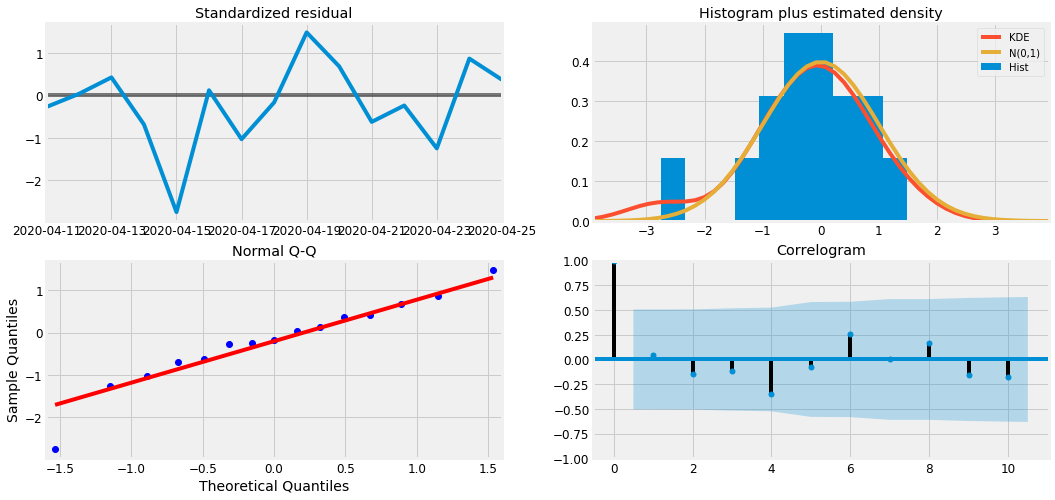

In [24]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

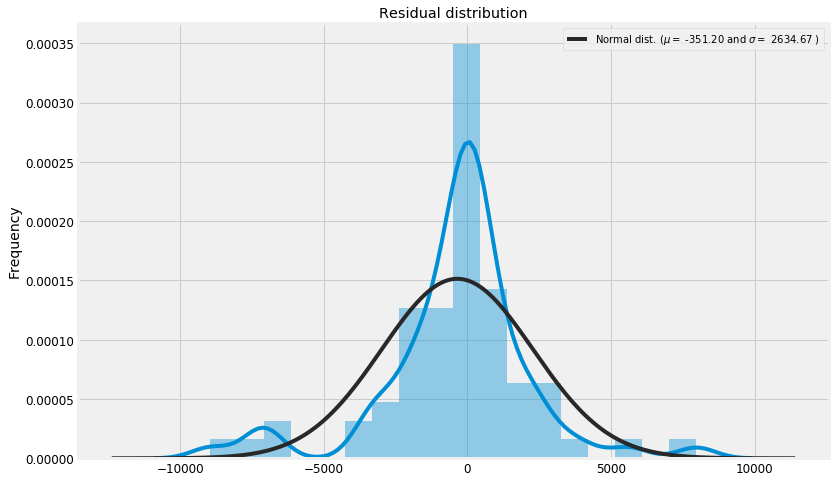

In [25]:
resid = results.resid

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing March as a reference point to start validating the forecasts.

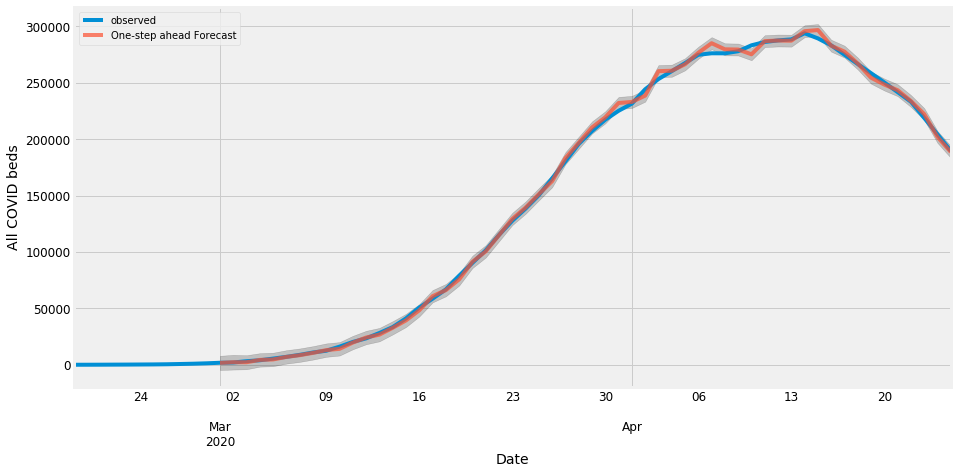

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [27]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2020-04-01':]
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 14193839.23


The MSE is very low.

In [28]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3767.47


In [29]:
ts.min()

57.08462142857141

In [30]:
ts.max()

293961.92172662885

This means that the value of RMSE is 3767.47. Also, the minimum and maximum values of time series is 57.08462142857141 and 293961.92172662885 respectively. Overall, this is a very good model so far.

# Visualizing forecasts

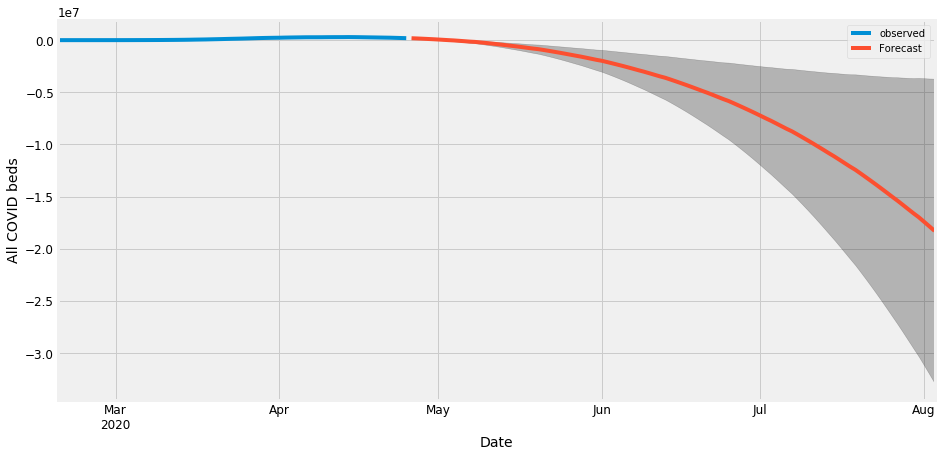

In [31]:
# Using the default confidence interval - 95%
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [32]:
# Setting all negative forecasted values to be 0
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean

2020-04-26   182639.8726
2020-04-27   162479.8292
2020-04-28   139515.9641
2020-04-29   115007.0974
2020-04-30    89877.3796
                 ...    
2020-07-30        0.0000
2020-07-31        0.0000
2020-08-01        0.0000
2020-08-02        0.0000
2020-08-03        0.0000
Freq: D, Length: 100, dtype: float64

In [33]:
pred_ci['lower value'][pred_ci['lower value'] < 0] = 0
pred_ci['upper value'][pred_ci['upper value'] < 0] = 0
pred_ci

,lower value,upper value
2020-04-26,177355.5904,187924.1548
2020-04-27,150921.8513,174037.8072
2020-04-28,121138.1169,157893.8113
2020-04-29,88996.7318,141017.4630
2020-04-30,55351.0674,124403.6918
...,...,...
2020-07-30,0.0000,0.0000
2020-07-31,0.0000,0.0000
2020-08-01,0.0000,0.0000
2020-08-02,0.0000,0.0000


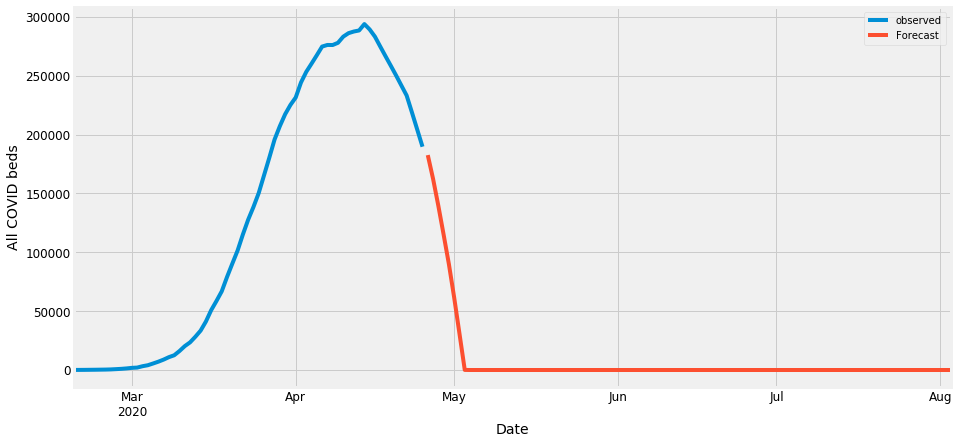

In [34]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

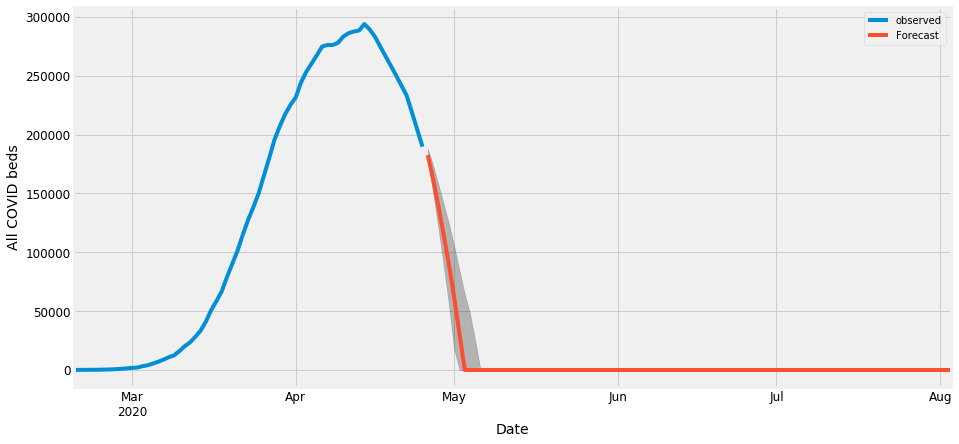

In [35]:
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

In [36]:
# Predictions dataframe
AllBedsPredictions = pd.DataFrame({'Predicted Mean All Beds':pred_uc.predicted_mean, 
                                   'Predicted lower value':pred_ci.iloc[:, 0], 
                                  'Predicted upper value': pred_ci.iloc[:, 1]})

In [37]:
AllBedsPredictions.head(25)

,Predicted Mean All Beds,Predicted lower value,Predicted upper value
2020-04-26,182639.8726,177355.5904,187924.1548
2020-04-27,162479.8292,150921.8513,174037.8072
2020-04-28,139515.9641,121138.1169,157893.8113
2020-04-29,115007.0974,88996.7318,141017.4630
2020-04-30,89877.3796,55351.0674,124403.6918
2020-05-01,61440.4906,17626.8036,105254.1776
2020-05-02,30895.7173,0.0000,84688.4493
2020-05-03,68.4505,0.0000,64493.1527
2020-05-04,0.0000,0.0000,47707.4521
2020-05-05,0.0000,0.0000,24404.8442
